In [1]:
import numpy as np
import tensorflow as tf
from decorator import append
from tensorflow.keras import layers, models, optimizers

# ------------------------------
# 1. Define CNN model
# ------------------------------
def build_model(input_shape=(4, 14, 1), num_classes=6):
    model = models.Sequential([
        layers.InputLayer(shape=input_shape),

        layers.Conv2D(8, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

        layers.Conv2D(16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(64),
        layers.ReLU(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.85),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ------------------------------
# 2. Initial Supervised Training
# ------------------------------
def train_initial_model(model, X_init, y_init, epochs=10, batch_size=32):
    model.fit(X_init, y_init, epochs=epochs, batch_size=batch_size, verbose=2)
    return model

# ------------------------------
# 3. Online Update with Pseudo-labels
# ------------------------------
def online_update(model, new_sample, pseudo_label, learning_rate=0.001):
    model.train_on_batch(new_sample, pseudo_label)
    return model

# ------------------------------
# 4. Pseudo-label generator (naive version)
# ------------------------------
def generate_pseudo_label(model, x):
    y_pred = model.predict(x, verbose=0)
    return np.argmax(y_pred, axis=1)


In [2]:
import self_supervised
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../Share/')
import baseline, config

import warnings
warnings.filterwarnings('ignore')

SUBJECT = "Hunmin"
trainer = baseline.ModelTrainer(config, subject=SUBJECT)
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=8)
print(X_init.shape, y_init.shape, X_init_test.shape, y_init_test.shape)

Dataset 1/55 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/55 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/55 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/


C:\Users\hml76\PycharmProjects\Tremor_project_local\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Dataset 4/55 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/55 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/55 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/55 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/55 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
(61191, 4, 14, 1) (61191,) (6799, 4, 14, 1) (6799,)


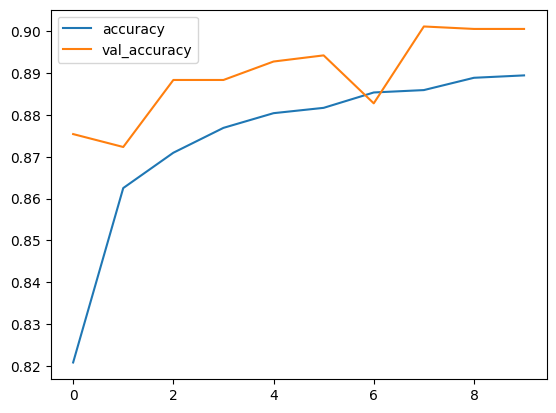

In [3]:
# 초기 학습 데이터
#X_init = np.random.rand(100, 4, 14, 1).astype(np.float32)
#y_init = np.random.randint(0, 6, size=(100,))

# 모델 생성 및 초기 학습
model = build_model()
result = model.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=10, batch_size=32, verbose=0)

plt.plot(result.history['accuracy'], label='accuracy')
plt.plot(result.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [4]:
Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
# 새로운 샘플 도착 (온라인 상황)

for session in range(8,50):  # 50개 샘플이 시간 순서로 도착
    new_X_train, new_y_train, new_X_test, new_y_test = trainer.return_K_th_data_only(K=session)

    # Pseudo label 생성
    pseudo_label = generate_pseudo_label(model, new_X_train)

    # 모델 업데이트 (online)
    model = online_update(model, new_X_train, pseudo_label)

    same_session_acc = model.evaluate(new_X_test, new_y_test, verbose=0)[1]
    print(f"Same session accuracy: {same_session_acc}")
    Same_Session_Test_Acc.append(same_session_acc)

    Unseen_X_train, Unseen_y_train, _, _ = trainer.return_K_th_data_only(K=session+1)
    next_session_acc = model.evaluate(Unseen_X_train, Unseen_y_train, verbose=0)[1]
    print(f"Next session accuracy: {next_session_acc}")
    Next_Session_Test_Acc.append(next_session_acc)

Returning K-th session data: Exp_2025-06-20-v7/E9AD0E7DCC2B/
Same session accuracy: 0.8779069781303406
Returning K-th session data: Exp_2025-06-20-v8/E9AD0E7DCC2B/
Next session accuracy: 0.8842783570289612
Returning K-th session data: Exp_2025-06-20-v8/E9AD0E7DCC2B/
Same session accuracy: 0.9013921022415161
Returning K-th session data: Exp_2025-06-23-v1/E9AD0E7DCC2B/
Next session accuracy: 0.892277717590332
Returning K-th session data: Exp_2025-06-23-v1/E9AD0E7DCC2B/
Same session accuracy: 0.8703271150588989
Returning K-th session data: Exp_2025-06-23-v2/E9AD0E7DCC2B/
Next session accuracy: 0.8338753581047058
Returning K-th session data: Exp_2025-06-23-v2/E9AD0E7DCC2B/
Same session accuracy: 0.8466042280197144
Returning K-th session data: Exp_2025-06-23-v3/E9AD0E7DCC2B/
Next session accuracy: 0.8498049378395081
Returning K-th session data: Exp_2025-06-23-v3/E9AD0E7DCC2B/
Same session accuracy: 0.8678362369537354
Returning K-th session data: Exp_2025-06-23-v4/E9AD0E7DCC2B/
Next session 

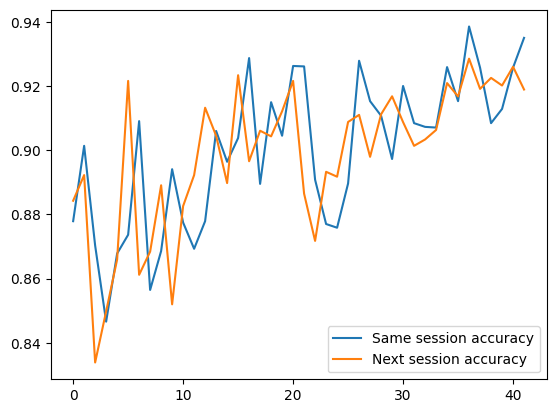

In [5]:
plt.plot(Same_Session_Test_Acc, label='Same session accuracy')
plt.plot(Next_Session_Test_Acc, label='Next session accuracy')
plt.legend()
plt.show()